In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/PPE Detection/venv/lib/python3.10/site-packages')

In [3]:

import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
import random
import pickle
from PIL import Image
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications import MobileNetV2

seed(1)
tf.random.set_seed(1)

In [4]:
%run '/content/drive/MyDrive/Colab Notebooks/PPE Detection/notebook/utils.ipynb'

In [5]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/PPE Detection/dataset'

SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 2

# MobileNetV2 - base model

## Model definition

In [6]:
EPOCHS = 400
DROPOUT_RATE = 0.5

In [7]:
class standardMobileNet:

  def __init__(self, train=None, test=None, val=None, name='MobileNetV2'):
    # set datasets
    self.train_path, self.val_path, self.test_path = train, val, test
    self.name=name
    self.history = None
    self.model = self.build_model()
    self.epochs = EPOCHS

    self.dir_name ="/content/drive/MyDrive/Colab Notebooks/PPE Detection/models/mobilenetV2"
    if not os.path.exists(self.dir_name):
      os.makedirs(self.dir_name)
    self.save_path = os.path.join(self.dir_name, name+'.h5')

    self.callbacks_list = [
      ks.callbacks.ModelCheckpoint(
          filepath=self.save_path,
          monitor="val_loss", #sum of the classification and regression losses
          verbose=1,
          save_best_only=True) #saves the best model in terms of the metric in monitor
      ]

  def build_model(self):
    input = ks.Input(shape=(SIZE, SIZE,3))
    input = layers.Rescaling(1. / 255)(input)

    mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
    mobilenet_base_model.trainable = False
    headModel = ks.applications.mobilenet_v2.preprocess_input(input)
    headModel = mobilenet_base_model(headModel)
    headModel = layers.GlobalAveragePooling2D()(headModel)
    headModel = layers.Dense(units=128, activation='relu')(headModel)
    headModel = layers.Dropout(DROPOUT_RATE)(headModel)

    label_output = layers.Dense(units= NUM_CLASSES, activation='softmax', name='classifier')(headModel)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(headModel)
    outputs = [label_output, bbox_output]

    return ks.Model(inputs=input, outputs=outputs)

  def compile_and_fit(self, optimizer='adam', learning_rate=None):
    if learning_rate is not None:
        optimizer.learning_rate = learning_rate

    self.model.compile(
        optimizer=optimizer,
        loss={'classifier': CategoricalCrossentropy(),
                 'regressor': MeanSquaredError()},
        loss_weights={'classifier': 1.0,
                 'regressor': 12.0},
        metrics={'classifier': 'accuracy',
                 'regressor': IoU_metric},
    )

    train_data_generator = data_generator(self.train_path, batch_size=BATCH_SIZE)
    val_data_generator = data_generator(self.val_path, batch_size=BATCH_SIZE)

    train_data, train_labels, train_boxes = next(train_data_generator)
    val_data, val_labels, val_boxes = next(val_data_generator)


    self.history = self.model.fit(
        train_data,
        [train_labels, train_boxes],
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        epochs=self.epochs,
        validation_data=(val_data, [val_labels, val_boxes]),
        validation_steps=len(val_data) // BATCH_SIZE,
        shuffle=True,
        callbacks=self.callbacks_list
    )

    self.save_history()

  def plot_model(self, model_name):
    ks.utils.plot_model(self.model, to_file=str(model_name) +".jpg", show_shapes=True)

  def load_best_model(self):
    custom_objects = {'IoU_metric': IoU_metric}
    self.model = ks.models.load_model(self.save_path, custom_objects=custom_objects)

  def save_history(self):
    with open(os.path.join(self.dir_name, self.name), 'wb') as file_pi:
      pickle.dump(self.history.history, file_pi)

  def load_history(self):
    with open(os.path.join(self.dir_name, self.name), 'rb') as file_pi:
      history = pickle.load(file_pi)
    self.history = history

  def load(self):
    self.load_best_model()
    self.load_history()

  def evaluate(self, test=None):
    if test is None:
        test = self.test_path
        test_data_generator = data_generator(test, batch_size=BATCH_SIZE)

    test_data, test_labels, test_boxes = [], [], []

    for batch_data, batch_labels, batch_boxes in test_data_generator:
      if (len(batch_data)==BATCH_SIZE and len(batch_labels)==BATCH_SIZE):
        test_data.append(batch_data)
        test_labels.append(batch_labels)
        test_boxes.append(batch_boxes)

    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_boxes = np.concatenate(test_boxes, axis=0)

    test_loss, classifier_loss, regressor_loss, classifier_accuracy, regressor_iou = self.model.evaluate(test_data, [test_labels, test_boxes], verbose=0)
    print(f"Test loss: {test_loss:.3f}")
    print(f"Classifier loss: {classifier_loss:.3f}")
    print(f"Regressor loss: {regressor_loss:.3f}")
    print(f"Classifier accuracy: {classifier_accuracy:.3f}")
    print(f"Regressor IoU: {regressor_iou:.3f}")

  def predict(self, test=None):
    if test is None:
        test = self.test_path
        test_data_generator = data_generator(test, batch_size=BATCH_SIZE)

    test_data, test_labels, test_boxes = [], [], []

    for batch_data, batch_labels, batch_boxes in test_data_generator:
      if (len(batch_data)==BATCH_SIZE and len(batch_labels)==BATCH_SIZE):
        test_data.append(batch_data)
        test_labels.append(batch_labels)
        test_boxes.append(batch_boxes)

    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_boxes = np.concatenate(test_boxes, axis=0)

    predictions = self.model.predict(test_data)
    test_labels = np.argmax(test_labels, axis=1)

    return test_data, predictions, test_labels, test_boxes

  def summary(self):
      self.model.summary()


##Model representation


In [8]:
mobilenet_model = standardMobileNet(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')
mobilenet_model.summary()
mobilenet_model.plot_model(model_name="MobileNetV2")

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['input_3[0][0]']             
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)          0         ['tf.math.truediv[1][0]']     
 da)                                                                                              
                               

##Model compile and fit

In [ ]:
mobilenet_model.compile_and_fit()

Epoch 1/400
1/1 [==============================] - ETA: 0s - loss: 3.1855 - classifier_loss: 0.8882 - regressor_loss: 0.1914 - classifier_accuracy: 0.6250 - regressor_IoU_metric: 0.0240
Epoch 1: val_loss improved from inf to 1.66266, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/MobileNetV2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 7s 7s/step - loss: 3.1855 - classifier_loss: 0.8882 - regressor_loss: 0.1914 - classifier_accuracy: 0.6250 - regressor_IoU_metric: 0.0240 - val_loss: 1.6627 - val_classifier_loss: 0.7340 - val_regressor_loss: 0.0774 - val_classifier_accuracy: 0.6094 - val_regressor_IoU_metric: 0.1901
Epoch 2/400
1/1 [==============================] - ETA: 0s - loss: 1.9358 - classifier_loss: 0.5638 - regressor_loss: 0.1143 - classifier_accuracy: 0.7031 - regressor_IoU_metric: 0.1036
Epoch 2: val_loss improved from 1.66266 to 1.55195, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/MobileNetV2.h5
1/1 [==============================] - 1s 651ms/step - loss: 1.9358 - classifier_loss: 0.5638 - regressor_loss: 0.1143 - classifier_accuracy: 0.7031 - regressor_IoU_metric: 0.1036 - val_loss: 1.5519 - val_classifier_loss: 0.5761 - val_regressor_loss: 0.0813 - val_classifier_accuracy: 0.6562 - val_regressor_IoU_metric: 0.2527
Epoch 3/400
1/1 [===

## Visualize results

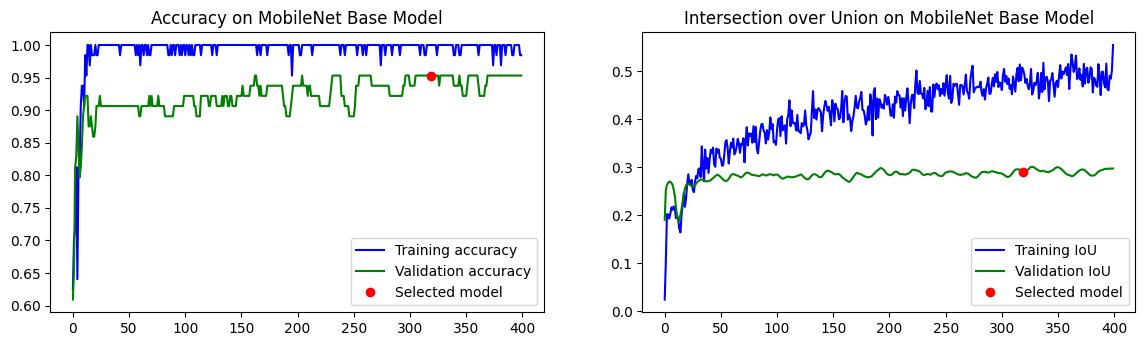

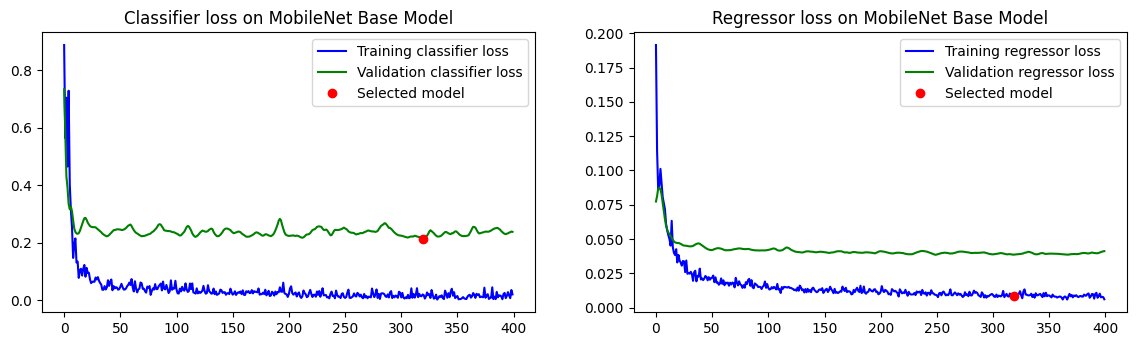

Lowest validation loss has been reached at epoch 319 with:
Training accuracy of 1.000 and Validation accuracy of 0.953 
Training IoU of 0.504 and Validation IoU of 0.290



<Figure size 640x480 with 0 Axes>

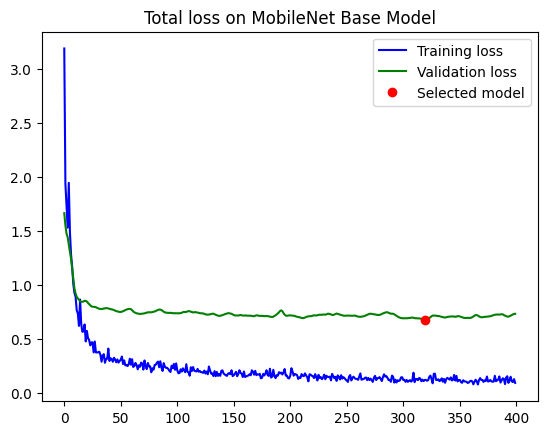

In [9]:
history = mobilenet_model.history.history if mobilenet_model.history is not None else (mobilenet_model.load() or mobilenet_model.history)
visualize_results('MobileNet Base Model', history)

## Evaluate against test set

In [ ]:
mobilenet_model.evaluate()

Test loss: 0.703
Classifier loss: 0.186
Regressor loss: 0.043
Classifier accuracy: 0.932
Regressor IoU: 0.245


In [11]:
test_data, predictions, actual_labels, actual_boxes = mobilenet_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 9s 38ms/step


Actual label:  vest


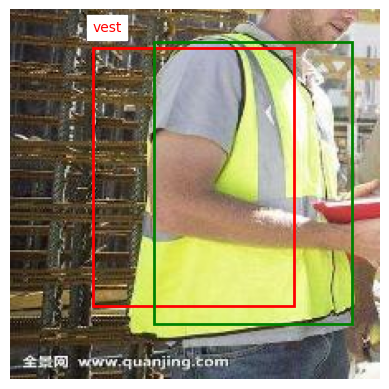

In [15]:
index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]
draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

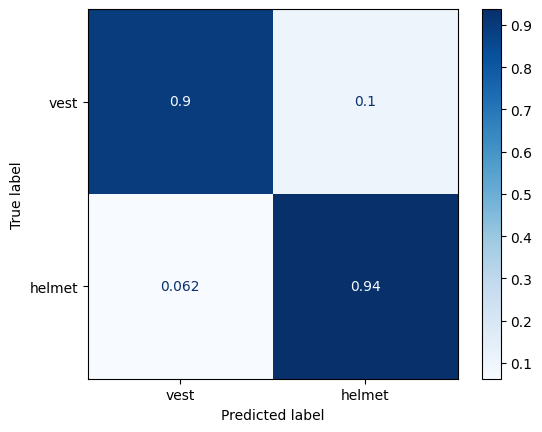

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# MobileNetV2 - Bigger model

## Model definition

In [19]:
EPOCHS = 600
DROPOUT_RATE = 0.6

In [20]:
class BiggerMobileNet(standardMobileNet):

  def __init__(self, dropout=None, train=None, test=None, val=None, name='Bigger MobileNet'):
      super().__init__(train=train, test=test, val=val, name=name)

  def build_model(self):
    input = ks.Input(shape=(SIZE, SIZE,3))
    input = layers.Rescaling(1. / 255)(input)

    mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
    mobilenet_base_model.trainable = False
    headModel = ks.applications.mobilenet_v2.preprocess_input(input)
    headModel = mobilenet_base_model(headModel)
    headModel = layers.GlobalAveragePooling2D()(headModel)
    headModel = layers.Dense(units=128, activation='relu')(headModel)
    headModel = layers.Dropout(DROPOUT_RATE)(headModel)
    headModel = layers.Dense(units=32, activation='relu')(headModel)
    headModel = layers.Dropout(DROPOUT_RATE)(headModel)

    label_output = layers.Dense(units= NUM_CLASSES, activation='softmax', name='classifier')(headModel)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(headModel)
    outputs = [label_output, bbox_output]

    return ks.Model(inputs=input, outputs=outputs)

##Model representation


In [21]:
bigger_model = BiggerMobileNet(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')
bigger_model.summary()
bigger_model.plot_model(model_name="Bigger MobileNetV2")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)          0         ['input_6[0][0]']             
 bda)                                                                                             
                                                                                                  
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)          0         ['tf.math.truediv_2[1][0]']   
 mbda)                                                                                            
                                                                                            

##Model compile and fit

In [ ]:
bigger_model.compile_and_fit()

Epoch 1/600
1/1 [==============================] - ETA: 0s - loss: 4.2564 - classifier_loss: 1.5167 - regressor_loss: 0.2283 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0027
Epoch 1: val_loss improved from inf to 2.17661, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/mobilenetV2/Bigger MobileNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 8s 8s/step - loss: 4.2564 - classifier_loss: 1.5167 - regressor_loss: 0.2283 - classifier_accuracy: 0.5000 - regressor_IoU_metric: 0.0027 - val_loss: 2.1766 - val_classifier_loss: 0.8734 - val_regressor_loss: 0.1086 - val_classifier_accuracy: 0.3750 - val_regressor_IoU_metric: 4.0209e-04
Epoch 2/600
1/1 [==============================] - ETA: 0s - loss: 3.6370 - classifier_loss: 1.2981 - regressor_loss: 0.1949 - classifier_accuracy: 0.5156 - regressor_IoU_metric: 0.0129
Epoch 2: val_loss improved from 2.17661 to 1.87354, saving model to /content/drive/MyDrive/Colab Notebooks/PPE Detection/models/mobilenetV2/Bigger MobileNet.h5
1/1 [==============================] - 1s 614ms/step - loss: 3.6370 - classifier_loss: 1.2981 - regressor_loss: 0.1949 - classifier_accuracy: 0.5156 - regressor_IoU_metric: 0.0129 - val_loss: 1.8735 - val_classifier_loss: 0.7353 - val_regressor_loss: 0.0949 - val_classifier_accuracy: 0.4531 - val_regressor_IoU_metric: 2.8127

## Visualize results

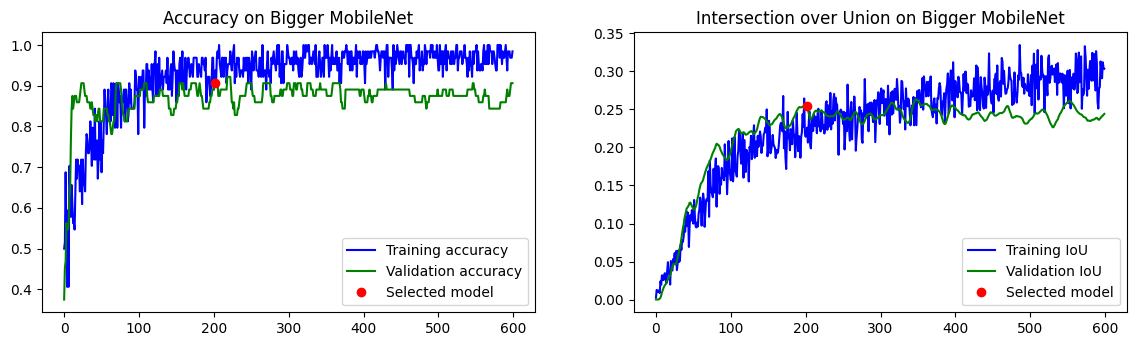

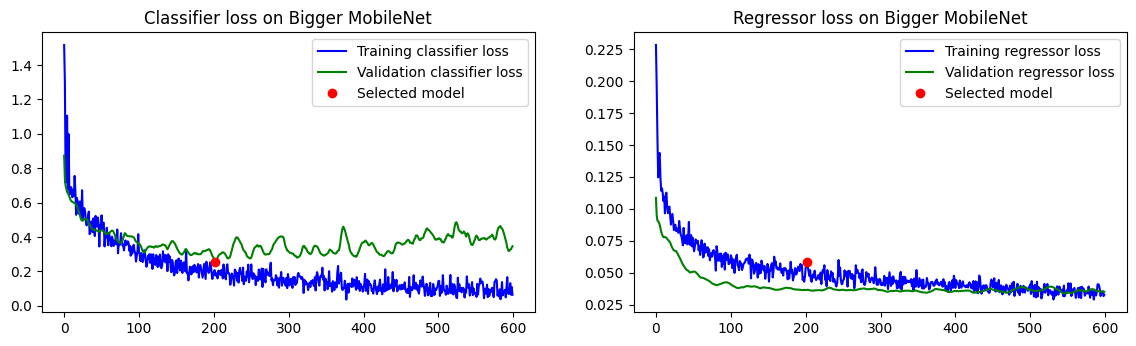

Lowest validation loss has been reached at epoch 202 with:
Training accuracy of 0.938 and Validation accuracy of 0.906 
Training IoU of 0.226 and Validation IoU of 0.254



<Figure size 640x480 with 0 Axes>

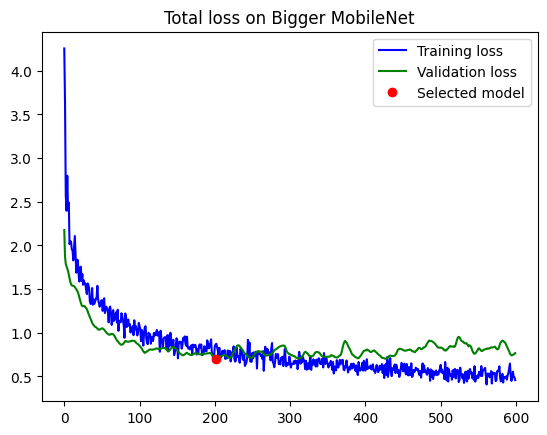

In [ ]:
history = bigger_model.history.history if bigger_model.history is not None else (bigger_model.load() or bigger_model.history)
visualize_results('Bigger MobileNet', history)

## Evaluate against test set

In [ ]:
bigger_model.evaluate()

Test loss: 0.822
Classifier loss: 0.299
Regressor loss: 0.044
Classifier accuracy: 0.911
Regressor IoU: 0.215


In [28]:
test_data, predictions, actual_labels, actual_boxes = bigger_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 0s 45ms/step


Actual label:  helmet


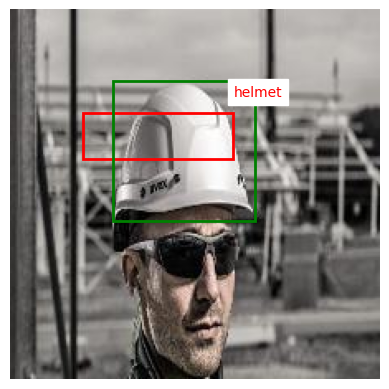

In [29]:
index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]
draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

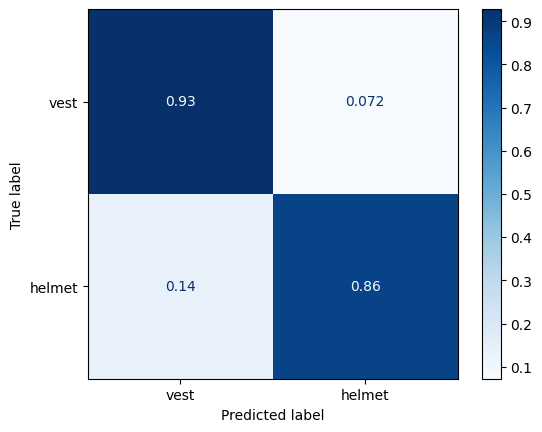

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# MobileNetV2 - Hyperparameters Tuning

## Model definition

In [30]:
EPOCHS = 200

In [31]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 879.4 kB/s eta 0:00:00


In [32]:
import keras_tuner as kt

class TuningMobileNet(standardMobileNet):

  def __init__(self, dropout=None, train=None, test=None, val=None, name='Tuning MobileNet'):
    super().__init__(train=train, test=test, val=val, name=name)

    self.log_dir = os.path.join(self.dir_name, 'tuning_log')
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)

  def build_tuned_model(self, hp):
    input = ks.Input(shape=(SIZE, SIZE, 3))
    input = layers.Rescaling(1. / 255)(input)

    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.8, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss_weight_classifier = hp.Float('loss_weight_classifier', min_value=1.0, max_value=10.0, step=1.0)
    hp_loss_weight_regressor = hp.Float('loss_weight_regressor', min_value=10.0, max_value=20.0, step=1.0)


    mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))
    mobilenet_base_model.trainable = False
    headModel = ks.applications.mobilenet_v2.preprocess_input(input)
    headModel = mobilenet_base_model(headModel)
    headModel = layers.GlobalAveragePooling2D()(headModel)

    headModel = layers.Dense(units=128, activation='relu')(headModel)
    headModel = layers.Dropout(hp_dropout)(headModel)
    headModel = layers.Dense(units=32, activation='relu')(headModel)
    headModel = layers.Dropout(hp_dropout)(headModel)

    label_output = layers.Dense(units=NUM_CLASSES, activation='softmax', name='classifier')(headModel)
    bbox_output = layers.Dense(units=4, activation='sigmoid', name='regressor')(headModel)
    outputs = [label_output, bbox_output]

    model = ks.Model(inputs=input, outputs=outputs)
    model.compile(
        optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
        loss={'classifier': CategoricalCrossentropy(),
              'regressor': MeanSquaredError()},
        loss_weights={'classifier': hp_loss_weight_classifier,
                      'regressor': hp_loss_weight_classifier},
        metrics={'classifier': Accuracy(),
                 'regressor': IoU_metric},
    )

    return model

  def tuning(self, optimizer='adam'):
    tuner = kt.Hyperband(
        self.build_tuned_model,
        objective=kt.Objective("val_loss", direction="min"),
        max_epochs=10,
        factor=3,
        directory=self.log_dir,
        project_name='mobilenet_tuning'
    )
    tuner.search_space_summary()

    train_data_generator = data_generator(self.train_path, batch_size=BATCH_SIZE)
    val_data_generator = data_generator(self.val_path, batch_size=BATCH_SIZE)

    train_data, train_labels, train_boxes = next(train_data_generator)
    val_data, val_labels, val_boxes = next(val_data_generator)


    tuner.search(
        train_data,
        {"classifier": train_labels, "regressor": train_boxes},
        epochs=10,
        validation_data=(val_data, [val_labels, val_boxes]),
        callbacks=[ks.callbacks.TensorBoard(self.log_dir)]
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"The hyperparameter search is complete. \
        The optimal hyperparameters are as follows:\n\
        - Learning rate for the optimizer: {best_hps.get('learning_rate')}\n\
        - Dropout rate: {best_hps.get('dropout')}\n\
        - Loss weight for classifier: {best_hps.get('loss_weight_classifier')}\n\
        - Loss weight for regressor: {best_hps.get('loss_weight_regressor')}")

    self.model = tuner.hypermodel.build(best_hps)

##Model representation


In [33]:
tuning_model = TuningMobileNet(train=dataset_path+'/train', val=dataset_path+'/valid', test=dataset_path+'/test')

In [ ]:
tuning_model.tuning()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss_weight_classifier (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 10.0, 'step': 1.0, 'sampling': 'linear'}
loss_weight_regressor (Float)
{'default': 10.0, 'conditions': [], 'min_value': 10.0, 'max_value': 20.0, 'step': 1.0, 'sampling': 'linear'}
The hyperparameter search is complete.         The optimal hyperparameters are as follows:
        - Learning rate for the optimizer: 0.0001
        - Dropout rate: 0.5
        - Loss weight for classifier: 1.0
        - Lo

In [ ]:
tuning_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.math.truediv_9 (TFOpLam  (None, 224, 224, 3)          0         ['input_30[0][0]']            
 bda)                                                                                             
                                                                                                  
 tf.math.subtract_9 (TFOpLa  (None, 224, 224, 3)          0         ['tf.math.truediv_9[1][0]']   
 mbda)                                                                                            
                                                                                            

##Model compile and fit

In [ ]:
tuning_model.compile_and_fit()

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.7469 - classifier_loss: 0.2306 - regressor_loss: 0.0430 - classifier_accuracy: 0.9219 - regressor_IoU_metric: 0.2119
Epoch 1: val_loss did not improve from 0.52973
1/1 [==============================] - 6s 6s/step - loss: 0.7469 - classifier_loss: 0.2306 - regressor_loss: 0.0430 - classifier_accuracy: 0.9219 - regressor_IoU_metric: 0.2119 - val_loss: 0.8226 - val_classifier_loss: 0.3922 - val_regressor_loss: 0.0359 - val_classifier_accuracy: 0.9062 - val_regressor_IoU_metric: 0.2216
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.6321 - classifier_loss: 0.1519 - regressor_loss: 0.0400 - classifier_accuracy: 0.9531 - regressor_IoU_metric: 0.2161
Epoch 2: val_loss did not improve from 0.52973
1/1 [==============================] - 0s 279ms/step - loss: 0.6321 - classifier_loss: 0.1519 - regressor_loss: 0.0400 - classifier_accuracy: 0.9531 - regressor_IoU_metric: 0.2161 - val_loss: 0.8330 - val_class

## Visualize results

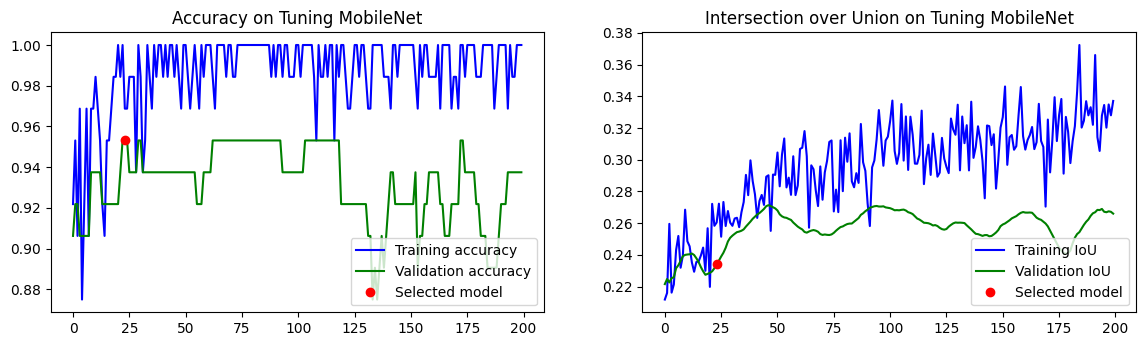

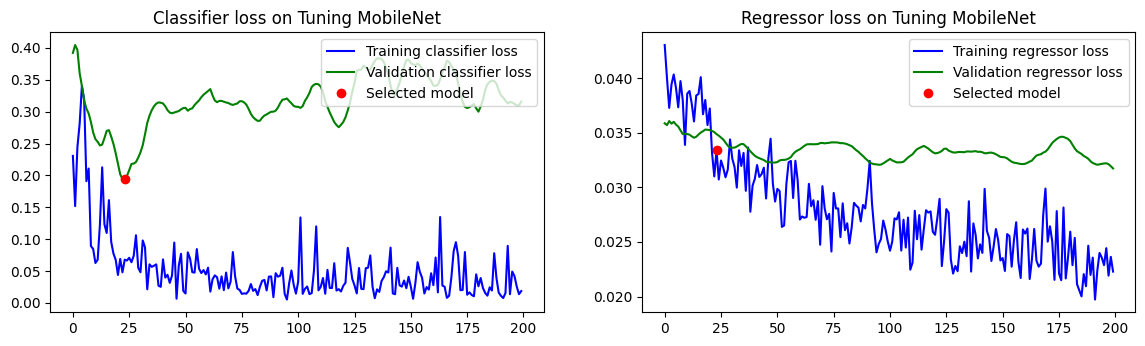

Lowest validation loss has been reached at epoch 23 with:
Training accuracy of 0.969 and Validation accuracy of 0.953 
Training IoU of 0.260 and Validation IoU of 0.234



<Figure size 640x480 with 0 Axes>

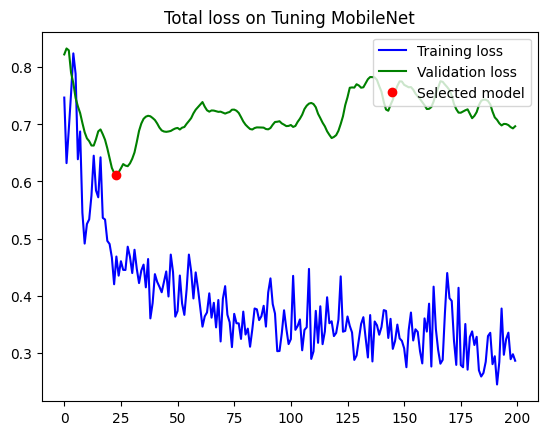

In [65]:
history = tuning_model.history.history if tuning_model.history is not None else (tuning_model.load() or bigger_model.history)
visualize_results('Tuning MobileNet', history)

## Evaluate against test set

In [ ]:
tuning_model.evaluate()

Test loss: 0.612
Classifier loss: 0.162
Regressor loss: 0.038
Classifier accuracy: 0.964
Regressor IoU: 0.240


In [51]:
test_data, predictions, actual_labels, actual_boxes = tuning_model.predict()
pred_labels = [np.argmax(pred) for pred in predictions[0]]
pred_boxes = predictions[1]

6/6 [==============================] - 0s 50ms/step


Actual label:  helmet


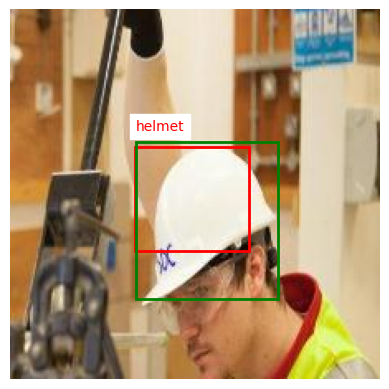

In [63]:
index = random.randint(0, len(test_data)-1)
image = Image.fromarray(test_data[index].astype(np.uint8))
predictions[0]
pred_label = pred_labels[index]
pred_box = pred_boxes[index]
actual_label = actual_labels[index]
actual_box = actual_boxes[index]
draw(image, pred_box*224, pred_label, actual_box*224, actual_label)

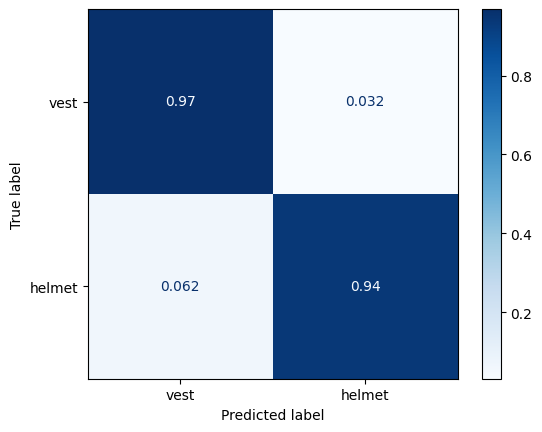

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# create and plot the confusion matrix
result = confusion_matrix(actual_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['vest', 'helmet'])
disp.plot(cmap=plt.cm.Blues)
plt.show()